# Exploring the Pokedex

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Let's start by loading the dataset into a pandas DataFrame.

In [97]:
df = pd.read_csv('pokemon.csv')

To get an understanding of the dataset, let's take a glance.

In [98]:
# Show the first five rows
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [99]:
# Show a summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
#             800 non-null int64
Name          800 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
Total         800 non-null int64
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Here's a quick description of each column:
- #: Pokedex entry number of the Pokemon
- Name: name of the Pokemon
- Type 1: primary type of the Pokemon
- Type 2: secondary type of the pokemon
- Total: sum of all the statistics
- HP: hit points or life
- Attack: determines attack power when using a physical move
- Defense: determines damage taken when hit by a physical move
- Sp. Atk: determines attack power when using a special move
- Sp. Def: determines damage taken when hit by a special move
- Speed: determines which Pokemon will attack first in each round
- Generation: refers to which set the Pokemon was released in
- Legendary: True if a Pokemon is considered a legendary Pokemon

## Key questions
1. How are Pokemon numbers distributed across generation?
2. What are the most common types of Pokemon?
3. What are the strongest and weakest Pokemon species?
4. What are the strongest and weakest Pokemon types?
5. Are there any trends regarding a Pokemon's statistics and its type?

## Cleaning the data
Prior knowledge of the Pokedex tells us that by generation 6, there are only 721 known Pokemon species, which suggests that we have duplicate rows in our dataset. Our initial inspection also revealed that we have missing values in *type 2*, which indicates that not all Pokemon species have a secondary type and we have to account for these missing values somehow. Furthermore, the dataset has two observational units: the Pokemon's identity and statistics, which should be normalized into two tables to prevent future inconsistencies. However, before any rigorous cleaning, let's do some housekeeping.

In [100]:
# Rename the # column to id
df.rename(columns={'#': 'id'}, inplace=True)

# Remove the Total column as this information is implicit
df.drop('Total', axis='columns', inplace=True)

# Convert all column labels to lower case
df.columns = df.columns.str.lower()

Now let's take a look at any potential duplicated rows via the *id* column.

In [101]:
df[df.duplicated('id', keep=False)].head()

,id,name,type 1,type 2,hp,attack,defense,sp. atk,sp. def,speed,generation,legendary
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
6,6,Charizard,Fire,Flying,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,78,104,78,159,115,100,1,False


We can definitely see that some Pokemon species have multiple forms but share the same *id* value. Since these additional forms represent the same Pokemon species albeit with higher statistics, let's exclude these duplicates in our analysis except for their first instance.

In [102]:
df.drop_duplicates('id', keep='first', inplace=True)

Since all Pokemon species have a primary type but not necessarily a secondary type, let's fill in the missing values in *type 2* with 'None'.

In [103]:
df['type 2'].fillna('None', inplace=True)

Since the dataset contains both identity and statistics information of each Pokemon species, let's separate these two observational units into separate tables, *pokedex* and *stats*, respectively.

In [104]:
# Select only the identity-related columns from original dataset
pokedex = df[['id', 'name', 'type 1', 'type 2', 'generation', 'legendary']]

# Join the new pokedex table with the original dataset to generate the
# stats table
stats = pd.merge(df, pokedex, on='id')[['id', 'hp', 'attack', 'defense', 
                                        'sp. atk', 'sp. def', 'speed']]

Now let's review the two tables along with our newly made changes.

In [105]:
pokedex.head()

,id,name,type 1,type 2,generation,legendary
0,1,Bulbasaur,Grass,Poison,1,False
1,2,Ivysaur,Grass,Poison,1,False
2,3,Venusaur,Grass,Poison,1,False
4,4,Charmander,Fire,None,1,False
5,5,Charmeleon,Fire,None,1,False


In [106]:
pokedex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721 entries, 0 to 799
Data columns (total 6 columns):
id            721 non-null int64
name          721 non-null object
type 1        721 non-null object
type 2        721 non-null object
generation    721 non-null int64
legendary     721 non-null bool
dtypes: bool(1), int64(2), object(3)
memory usage: 34.5+ KB


In [107]:
stats.head()

,id,hp,attack,defense,sp. atk,sp. def,speed
0,1,45,49,49,65,65,45
1,2,60,62,63,80,80,60
2,3,80,82,83,100,100,80
3,4,39,52,43,60,50,65
4,5,58,64,58,80,65,80


In [108]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721 entries, 0 to 720
Data columns (total 7 columns):
id         721 non-null int64
hp         721 non-null int64
attack     721 non-null int64
defense    721 non-null int64
sp. atk    721 non-null int64
sp. def    721 non-null int64
speed      721 non-null int64
dtypes: int64(7)
memory usage: 45.1 KB


Everything looks good! It's now time to answer those questions.

## 1. How are Pokemon numbers distributed across generation?

Let's begin by taking a look at the total number of Pokemon within each generation.

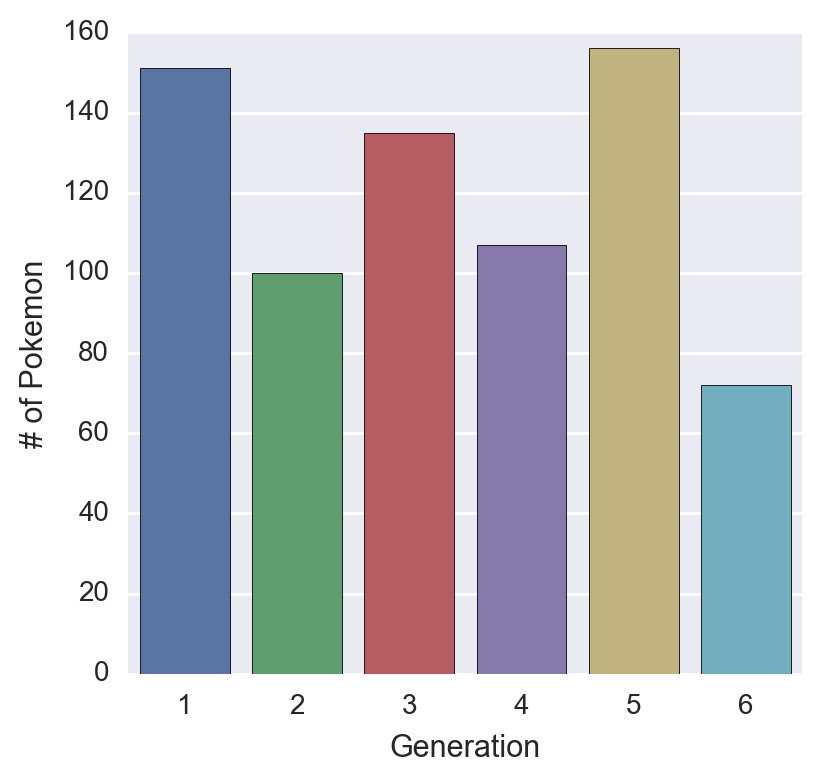

In [109]:
# Display a categorial histogram and label axes
sns.factorplot(
    x='generation', 
    data=pokedex, 
    kind='count'
).set_axis_labels('Generation', '# of Pokemon');

There doesn't seem to be a trend across generations; however, even-numbered generations introduced fewer Pokemon as compared to the odd-numbered generations.

Prior knowledge tells us that a Pokemon's primary type (*type 1*) is typically associated with its appearance and moves, so let's dig deeper and examine the distribution of primary types across generation.

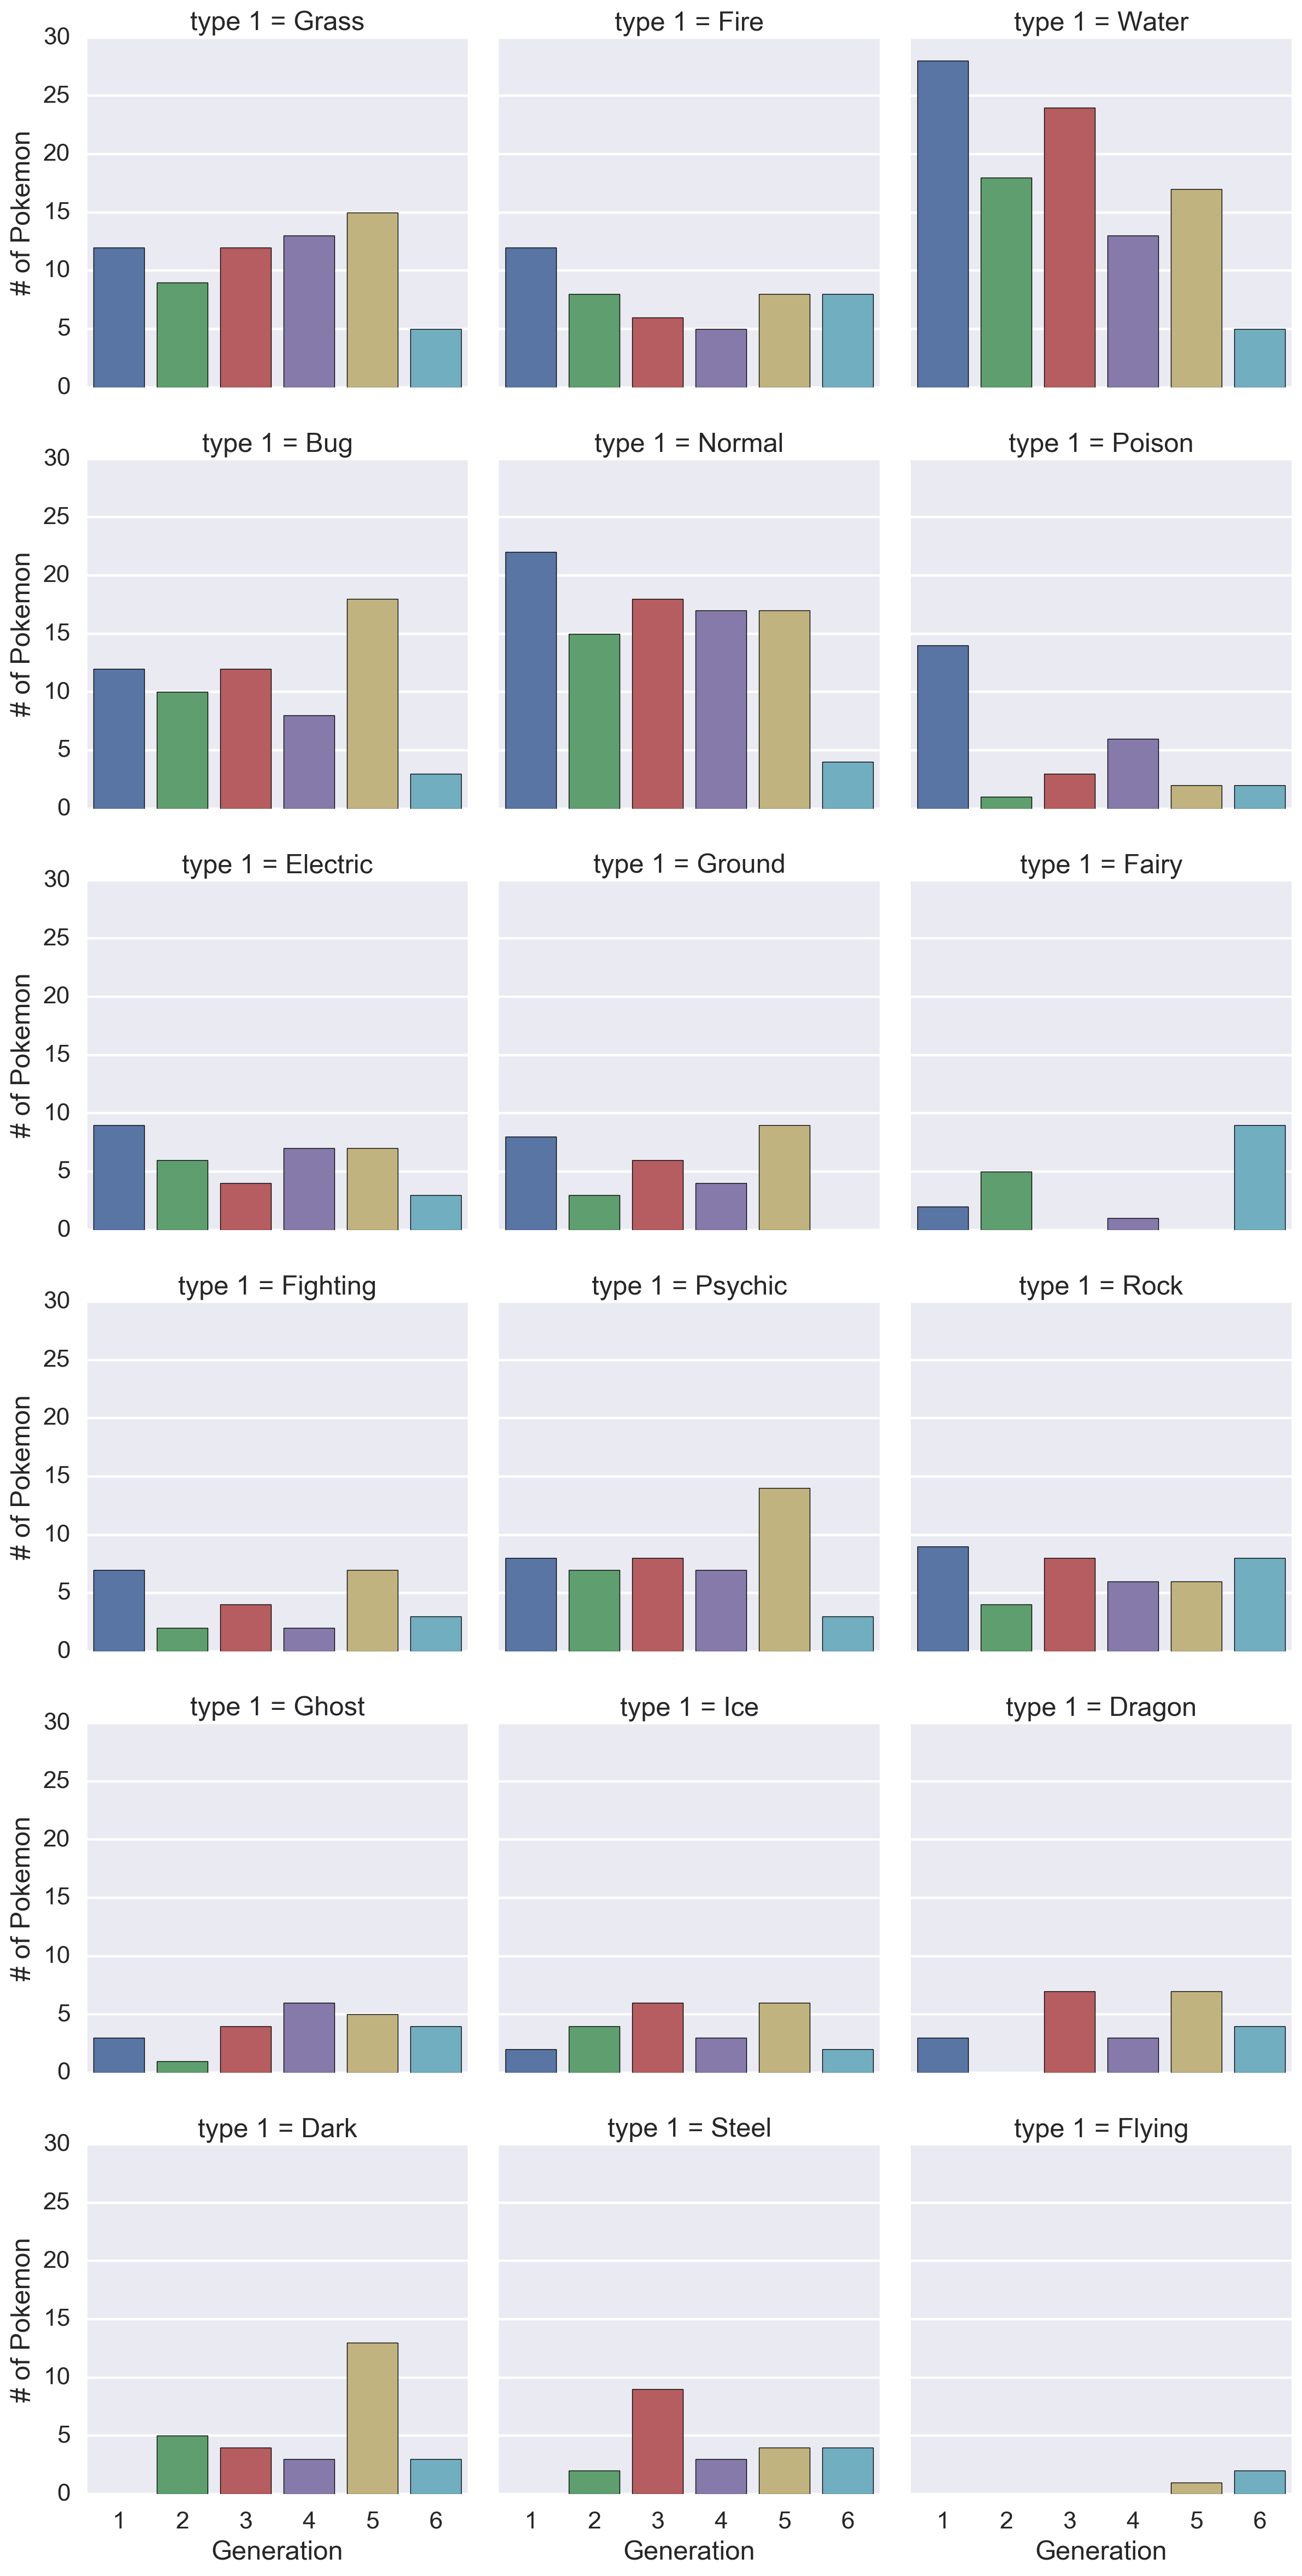

In [110]:
# Set the font scale for better readability 
sns.set_context('poster')

# Display a categorical histogram, faceted by primary type, and label axes
sns.factorplot(
    x='generation',
    data=pokedex,
    col='type 1',
    kind='count',
    col_wrap=3
).set_axis_labels('Generation', '# of Pokemon');

A few conclusions can be drawn from these plots:
- Poison-type Pokemon were popular in generaiton 1 but they have been added less and less in later generations.
- Generation 5 received a surge of new Psychic- and Dark-type Pokemon, while Steel-type Pokemon received a large boost in generation 3.
- Normal-type Pokemon had a strong presence in every generation except generation 6.

## 2. What are the most common types of Pokemon?

Let's begin by investigating if there are any unique primary or secondary Pokemon types, or if they share the same ones.

In [111]:
# Compute the unique types between primary and secondary types, and vice versa
unique_type1 = np.setdiff1d(pokedex['type 1'], pokedex['type 2'])
unique_type2 = np.setdiff1d(pokedex['type 2'], pokedex['type 1'])

# Display any unique primary types
print('Unique Type 1: ', end='')
if unique_type1.size == 0:
    print('No unique types')
else:
    for unique_type in unique_type1:
        print(unique_type)

# Display any unique secondary types
print('Unique Type 2: ', end='')
if unique_type2.size == 0:
    print(0)
else:
    for unique_type in unique_type2:
        print(unique_type)

Unique Type 1: No unique types
Unique Type 2: None


There are no unique primary types but as noted earlier, some Pokemon species do not have a secondary type and thus noted by the the unique type of 'None'. Armed with this information, let's count the total number of primary and secondary types.

In [112]:
# Group by primary or secondary type, and compute the total number in each group
type1, type2 = pokedex.groupby('type 1'), pokedex.groupby('type 2')
print('Type 1 count: {}'.format(len(type1)))
print('Type 2 count: {}'.format(len(type2)))

Type 1 count: 18
Type 2 count: 19


There are a total of 18 primary types and 19 secondary types (again, the extra secondary type refers to Pokemon species without a secondary type). 

To understand the most common primary and secondary types, let's examine the distributions for each.

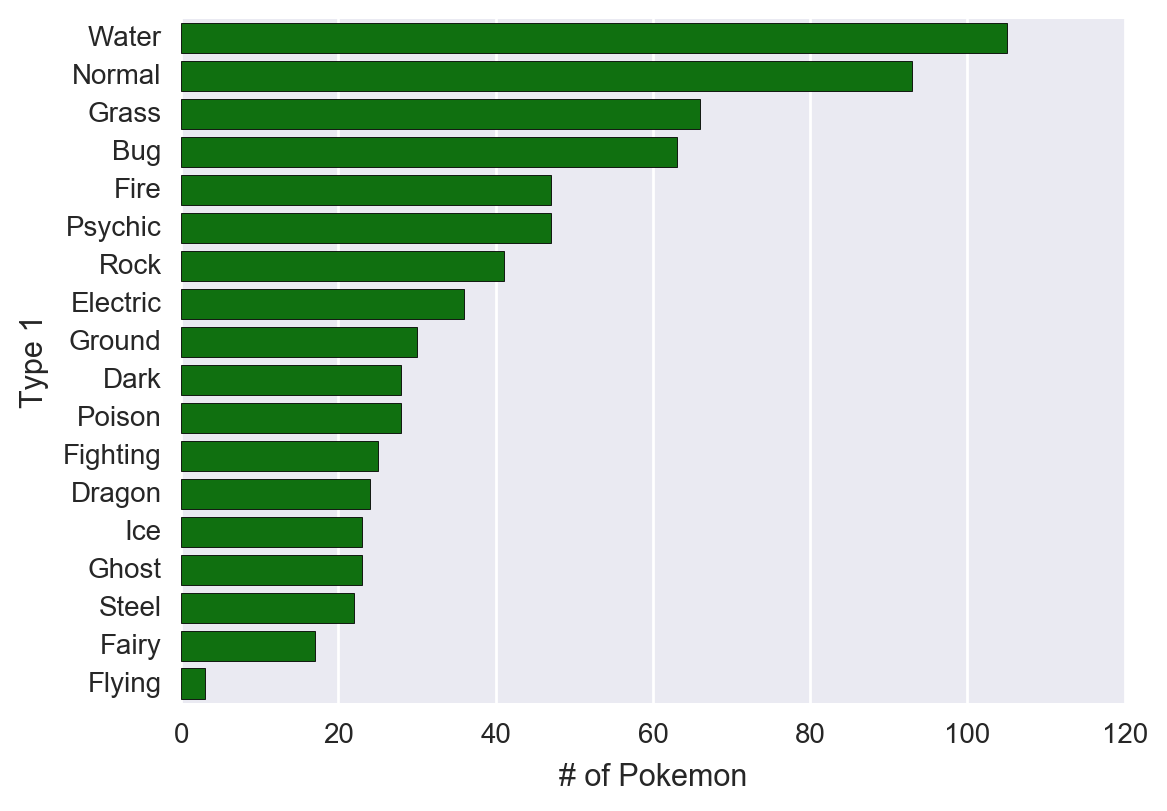

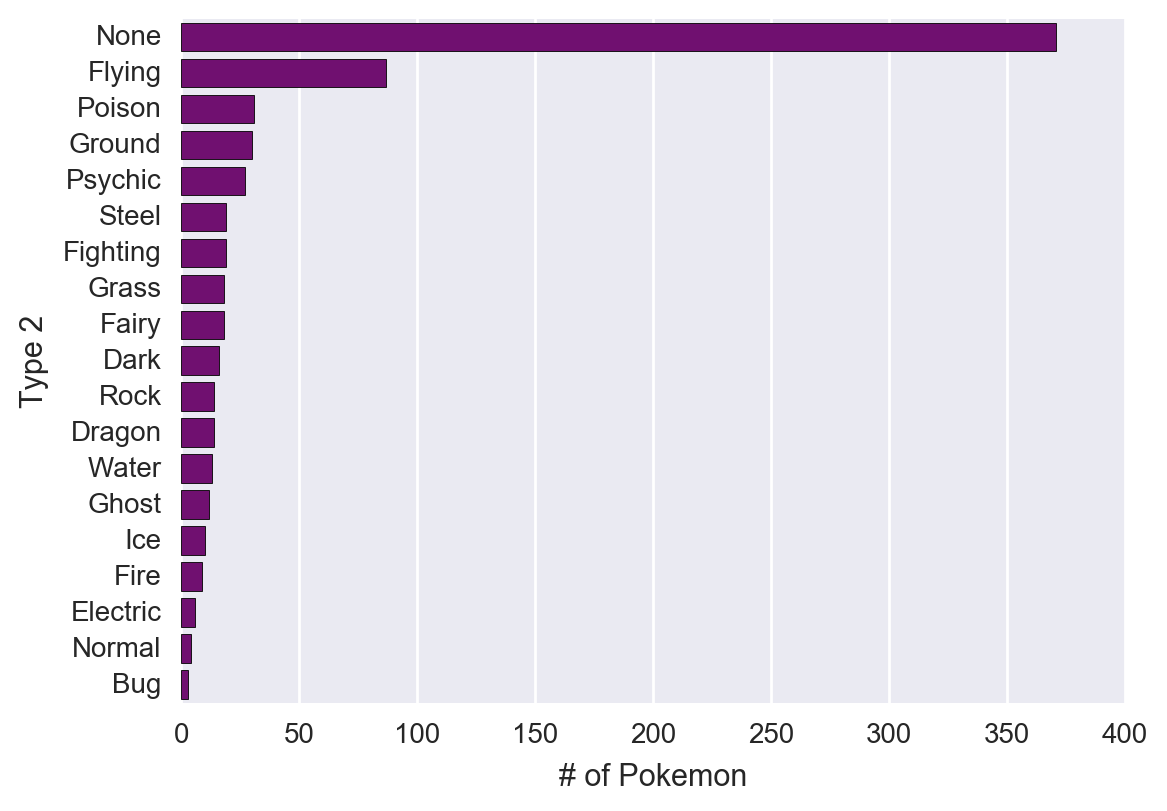

In [113]:
# Set the font scale for better readability 
sns.set_context('notebook')

# Displays categorical histogram of primary types and sort by largest counts
sns.factorplot(
    y='type 1',
    data=pokedex,
    kind='count',
    order=pokedex['type 1'].value_counts().index,
    aspect=1.5,
    color='green'
).set_axis_labels('# of Pokemon', 'Type 1')

# Displays categorical histogram of secondary types and sort by largest counts
sns.factorplot(
    y='type 2',
    data=pokedex,
    kind='count',
    order=pokedex['type 2'].value_counts().index,
    aspect=1.5,
    color='purple'
).set_axis_labels('# of Pokemon', 'Type 2');

We can draw a few conclusions from these plots:
- Nearly half of Pokemon species only have a primary type
- Normal-type Pokemon are very common, which makes sense as these are considered a "generic" type. However, it's surprising that they're outnumbered by Water-type Pokemon.
- Pokemon species with a secondary type are typically Flying-type--nearly 1 in 7 Pokemon can fly.
- Pokemon with Flying-type as the primary type are very rare.

These findings are insightful but it would be more interesting to investigate the the distribution of the various combinations of primary and secondary types.

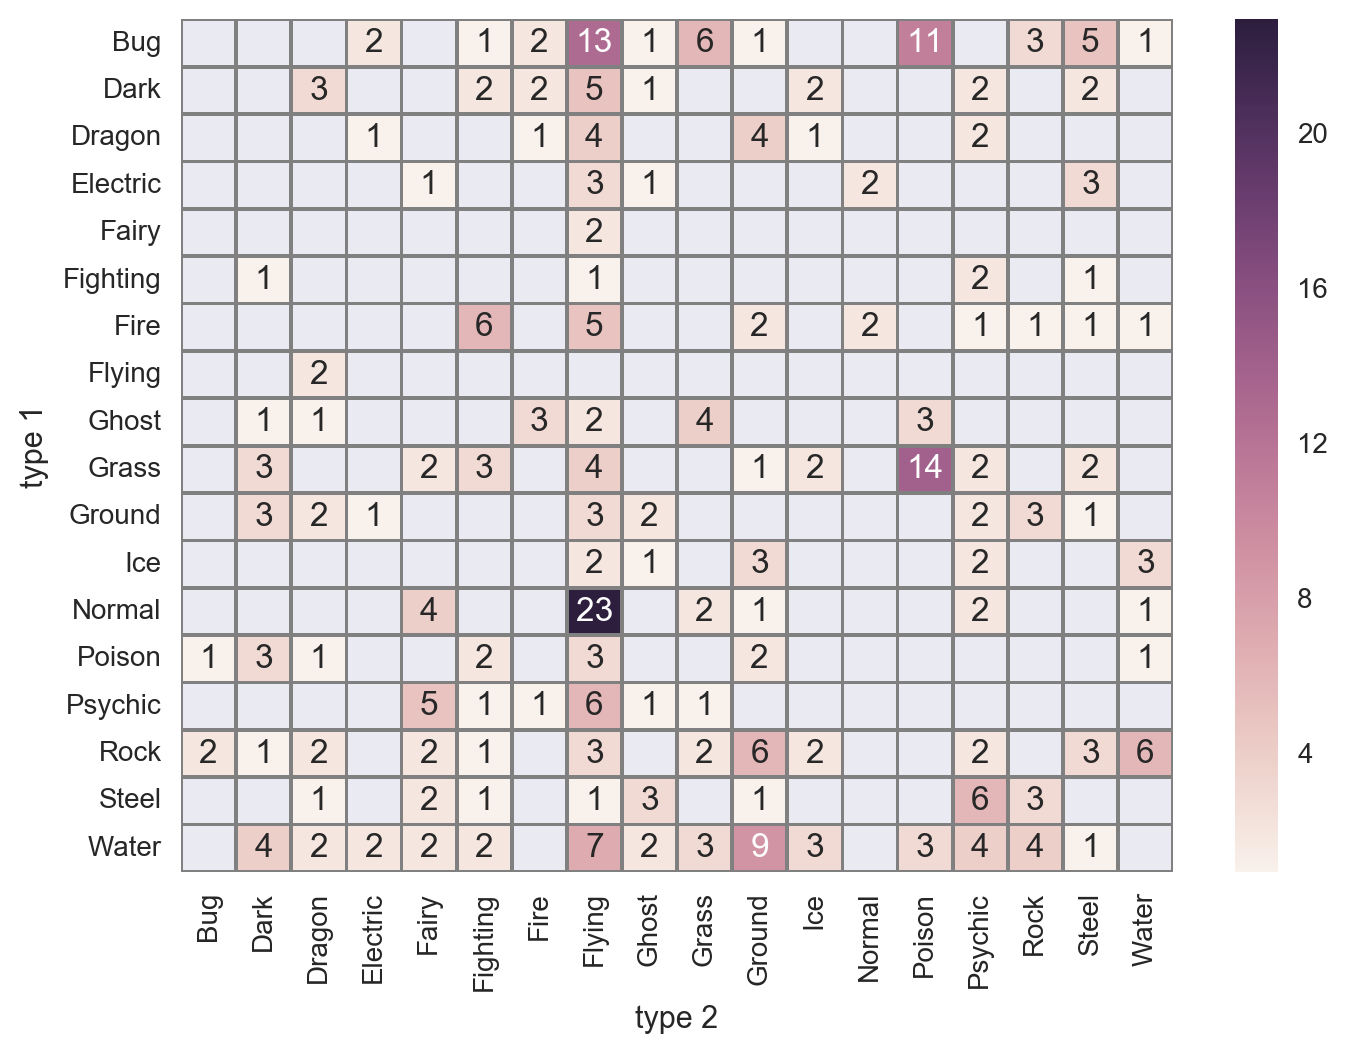

In [114]:
# Select Pokemon species with both a primary and secondary type to better 
# highlight results
dual_types = pokedex[pokedex['type 2'] != 'None']

# Display a heatmap using the primary and secondary types, and display the
# number of Pokemon with each combination. Note that the heatmap() function 
# requires the dataset to be 2D--hence the unstack().
sns.heatmap(
    dual_types.groupby(['type 1', 'type 2']).size().unstack(),
    linewidths=1,
    linecolor='grey',
    annot=True
);

This plot reveals that several type combinations are exceedingly common: 
- Normal/Flying
- Bug/Flying
- Bug/Poison
- Grass/Poison
- Water/Ground

It's a bit paradoxical there actually exist Pokemon species that are Fire/Water-type and Ground/Flying-type. 

Finally, let's take a look at the distribution of types for those Pokemon species that don't have a secondary type.

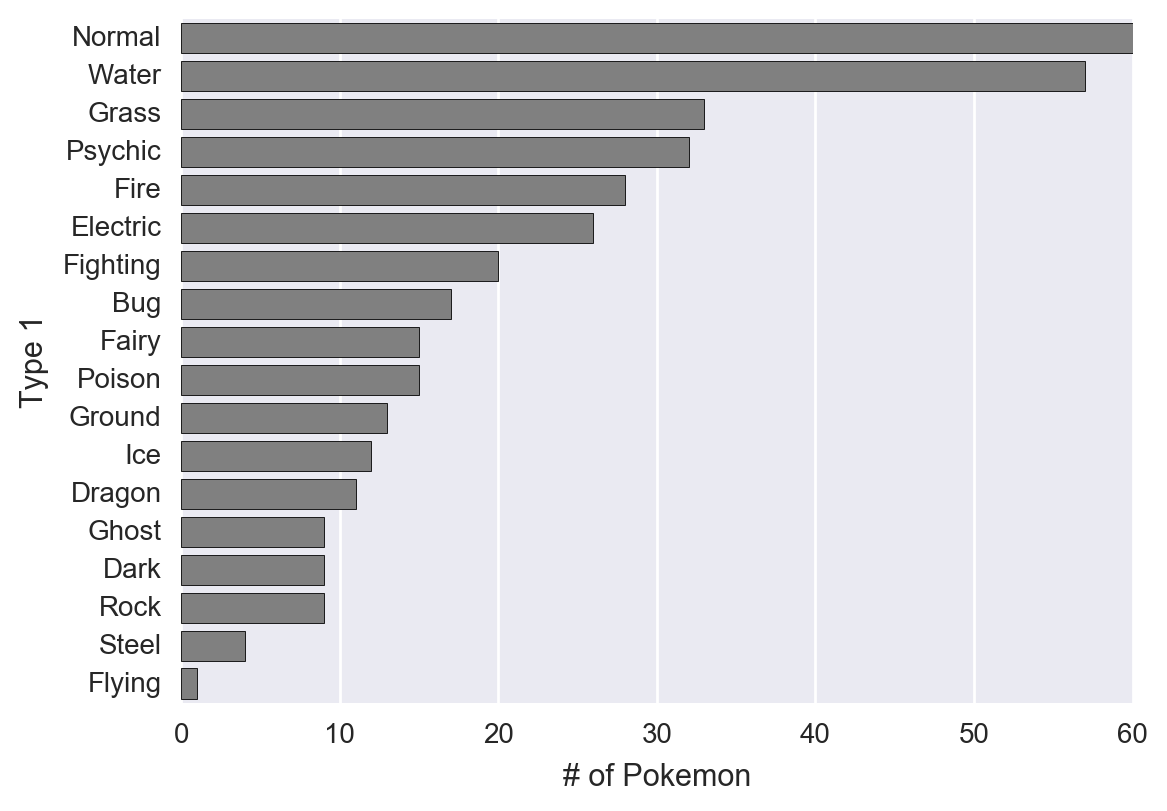

In [115]:
sns.set_context('notebook')

# Select any Pokemon with only a primary type
single_types = pokedex[pokedex['type 2'] == 'None']

# Display categorical histogram and sort by largest counts
sns.factorplot(
    y='type 1', 
    data=single_types,
    kind='count',
    order=single_types['type 1'].value_counts().index,
    aspect=1.5,
    color='grey'
).set_axis_labels('# of Pokemon', 'Type 1');

Nothing too surprising here besides the considerably large proportion of Pokemon that are only Normal- or Water-type!
## 3. What are the strongest and weakest Pokemon species?
Let's begin by normalizing the six statistic columns via z-scores so we can make fair comparisons between them. We'll define Pokemon "strength" as the sum of the z-scores of each statistic--the higher the value, the stronger the Pokemon (let's assume each statistic is weighted equally).

In [116]:
# Generate a new DataFrame to store normalized statistics
norm_stats = stats.copy()

In [117]:
# Normalize each statistic via a z-score
for stat in stats.loc[:, 'hp':'speed']:
    norm_stats[stat] = stats[stat].apply(
        lambda x: (x - stats[stat].mean()) / stats[stat].std())

# Compute the strength of each Pokemon species as the sum of the z-scores for 
# each statistic and store the result in a new column
norm_stats['total'] = norm_stats.loc[:, 'hp':'speed'].sum(axis='columns')

In [118]:
# Join the norm_stats table with the pokedex table based on id number to report
# the ten highest strengths
pd.merge(
    pokedex, 
    norm_stats, 
    on='id'
).sort_values('total', ascending=False).head(10)

,id,name,type 1,type 2,generation,legendary,hp,attack,defense,sp. atk,sp. def,speed,total
492,493,Arceus,Normal,None,4,True,1.997038,1.543676,1.688730,1.770023,1.889253,1.990097,10.878816
486,487,GiratinaAltered Forme,Ghost,Dragon,4,True,3.157657,0.855689,1.688730,1.077948,1.889253,0.890307,9.559583
248,249,Lugia,Psychic,Flying,2,True,1.455415,0.511696,2.031255,0.731910,3.153223,1.623500,9.507000
249,250,Ho-oh,Fire,Flying,2,True,1.455415,1.887669,0.661154,1.423986,3.153223,0.890307,9.471754
715,716,Xerneas,Fairy,None,6,True,2.229161,1.922068,0.832417,2.150665,1.071389,1.220244,9.425945
716,717,Yveltal,Dark,Flying,6,True,2.229161,1.922068,0.832417,2.150665,1.071389,1.220244,9.425945
149,150,Mewtwo,Psychic,None,1,True,1.455415,1.199683,0.661154,2.946551,0.773985,2.356694,9.393482
642,643,Reshiram,Dragon,Fire,5,True,1.223292,1.543676,1.003679,2.808136,1.889253,0.890307,9.358342
483,484,Palkia,Water,Dragon,4,True,0.836418,1.543676,1.003679,2.808136,1.889253,1.256904,9.338066
383,384,Rayquaza,Dragon,Flying,3,True,1.416728,2.575656,0.661154,2.808136,0.773985,1.073605,9.309264


The ten strongest Pokemon species are, in order, Arceus, Giratina, Lugia, Ho-oh and Xerneas, Yveltal, Mewtwo, Reshiram, Palkia and Rayquaza. Not surprisingly, they are all legendary Pokemon. And even less surprising, Arceus is considered the "god" Pokemon. 

Now let's take a look at the weakest Pokemon.

In [119]:
# Join the norm_stats table with the pokedex table based on id number to report
# the ten lowest strengths
pd.merge(
    pokedex,
    norm_stats,
    on='id'
).sort_values('total', ascending=False).tail(10)

,id,name,type 1,type 2,generation,legendary,hp,attack,defense,sp. atk,sp. def,speed,total
348,349,Feebas,Water,None,3,False,-1.871693,-2.068254,-1.736521,-2.036391,-0.527161,0.523710,-7.716310
128,129,Magikarp,Water,None,1,False,-1.871693,-2.240250,-0.537684,-1.863372,-1.828307,0.523710,-7.817596
663,664,Scatterbug,Bug,None,6,False,-1.175321,-1.380267,-1.051471,-1.448127,-1.642429,-1.125976,-7.823592
279,280,Ralts,Psychic,Fairy,3,False,-1.562194,-1.724260,-1.565259,-0.825259,-1.270673,-0.942678,-7.890324
9,10,Caterpie,Bug,None,1,False,-0.904510,-1.552264,-1.222734,-1.690353,-1.828307,-0.759379,-7.957548
12,13,Weedle,Bug,Poison,1,False,-1.097947,-1.380267,-1.393996,-1.690353,-1.828307,-0.576081,-7.966952
264,265,Wurmple,Bug,None,3,False,-0.904510,-1.036274,-1.222734,-1.690353,-1.456551,-1.675871,-7.986294
400,401,Kricketot,Bug,None,4,False,-1.214009,-1.724260,-1.017219,-1.517334,-1.047620,-1.492573,-8.013015
297,298,Azurill,Normal,Fairy,3,False,-0.711074,-1.896257,-1.051471,-1.690353,-1.084795,-1.675871,-8.109822
190,191,Sunkern,Grass,None,2,False,-1.484820,-1.552264,-1.393996,-1.344315,-1.456551,-1.309275,-8.541221


The ten weakest Pokemon species are, in order, Sunkern, Azurill, Kricketot, Wurmpie, Weedle, Caterpie, Ralts, Scatterbug, Magikarp and Feebas. It's intriguing that many of these Pokemon species are Bug-type...

It would also be worth identifying the ten strongest non-legendary Pokemon since these are easier to catch in-game as compared to legendary ones.

In [120]:
# Join the norm_stats table with the pokedex table based on id number to report
# the ten highest strenghts for non-legendary Pokemon
pd.merge(
    pokedex[~pokedex['legendary']],
    norm_stats,
    on='id'
).sort_values('total', ascending=False).head(10)

,id,name,type 1,type 2,generation,legendary,hp,attack,defense,sp. atk,sp. def,speed,total
277,289,Slaking,Normal,None,3,False,3.157657,2.919649,1.003679,0.904929,-0.155405,1.256904,9.087412
658,706,Goodra,Dragon,None,6,False,0.836418,0.855689,-0.023896,1.423986,3.004521,0.523710,6.620428
423,445,Garchomp,Dragon,Ground,4,False,1.532790,1.887669,0.832417,0.385873,0.588107,1.330223,6.557078
599,635,Hydreigon,Dark,Dragon,5,False,0.913793,1.027686,0.661154,1.943042,0.773985,1.183584,6.503244
361,373,Salamence,Dragon,Flying,3,False,1.029855,2.059666,0.318629,1.423986,0.402229,1.256904,6.491268
145,149,Dragonite,Dragon,Flying,1,False,0.875106,2.025266,0.832417,1.077948,1.145741,0.523710,6.480187
239,248,Tyranitar,Rock,Dark,2,False,1.223292,2.025266,1.346204,0.904929,1.145741,-0.172824,6.472608
364,376,Metagross,Steel,Psychic,3,False,0.449545,2.059666,2.031255,0.904929,0.773985,0.157113,6.376493
531,567,Archeops,Rock,Flying,5,False,0.256109,2.231662,-0.195159,1.493193,-0.155405,1.623500,5.253901
236,242,Blissey,Normal,None,2,False,7.219824,-2.240250,-2.079047,0.212854,2.446887,-0.392782,5.167485


The five strongest non-legendary Pokemon species are, in order, Slaking, Goodra, Garchomp, Hyregion, Salamence, Dragonite, Tyranitar, Metagross, Archeops and Blissey. It's intriguing that many of these are Dragon-type Pokemon...

## 4. What are the strongest and weakest types of Pokemon?

Since our last analysis hinted that certain Pokemon types may be correlated with strength, let's begin by taking a look at the strongest types of Pokemon of each primary and secondary type combination. Since the strengths of each type are likely not normally distributed, let's use the median as our metric.

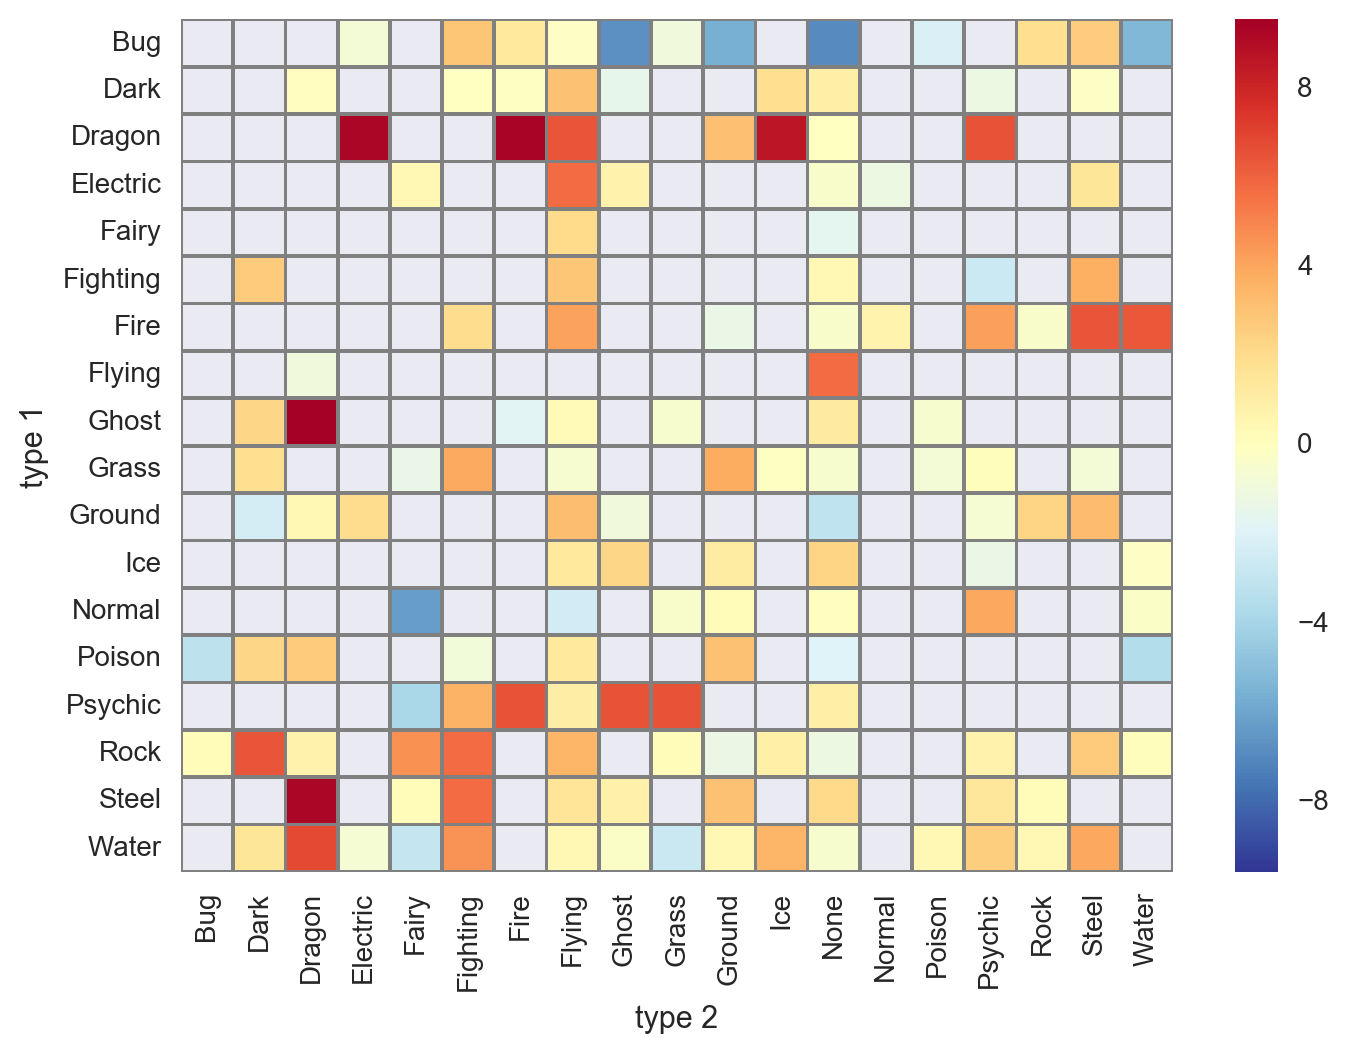

In [121]:
# Join the norm_stats table with the pokedex table based on id number
joined = pd.merge(
    pokedex,
    norm_stats,
    on='id'
)

# Calculate the median strength of each primary and secondary type combination
medians = joined.groupby(['type 1', 'type 2'])['total'].median()

# Display a heatmap of the median strength of each primary and secondary type
# combination
sns.heatmap(
    medians.unstack(),
    linewidths=1,
    cmap='RdYlBu_r',
    linecolor='grey'
);

The heatmap is teeming with information but it's difficult to determine the strongest type combinations. Let's identify the top five.

In [122]:
# Rearrange the medians table and sort by the strongest primary and secondary 
# type combination
medians.reset_index().sort_values('total', ascending=False).head()

,type 1,type 2,total
53,Ghost,Dragon,9.559583
22,Dragon,Fire,9.358342
119,Steel,Dragon,9.299880
21,Dragon,Electric,9.293747
25,Dragon,Ice,8.702948


We can draw a few conclusions from these data:
- Among the strongest Pokemon are Dragon-type (as primary or secondary), Psychic-type (as primary), Fighting-type (as secondary) and Flying-type (as secondary).
- Among the weakest Pokemon are Bug-type (as primary).
- The five strongest primary and secondary type combinations are, in order, Ghost/Dragon, Dragon/Fire, Steel/Dragon, Dragon/Electric and Dragon/Ice.

Since legendary Pokemon species are a) few in number and b) known to be typically much stronger than non-legendary Pokemon, the former group may be skewing the results. Therefore, let's take a look at the same analysis as above but excluding  legendary Pokemon and then list the five strongest combinations.

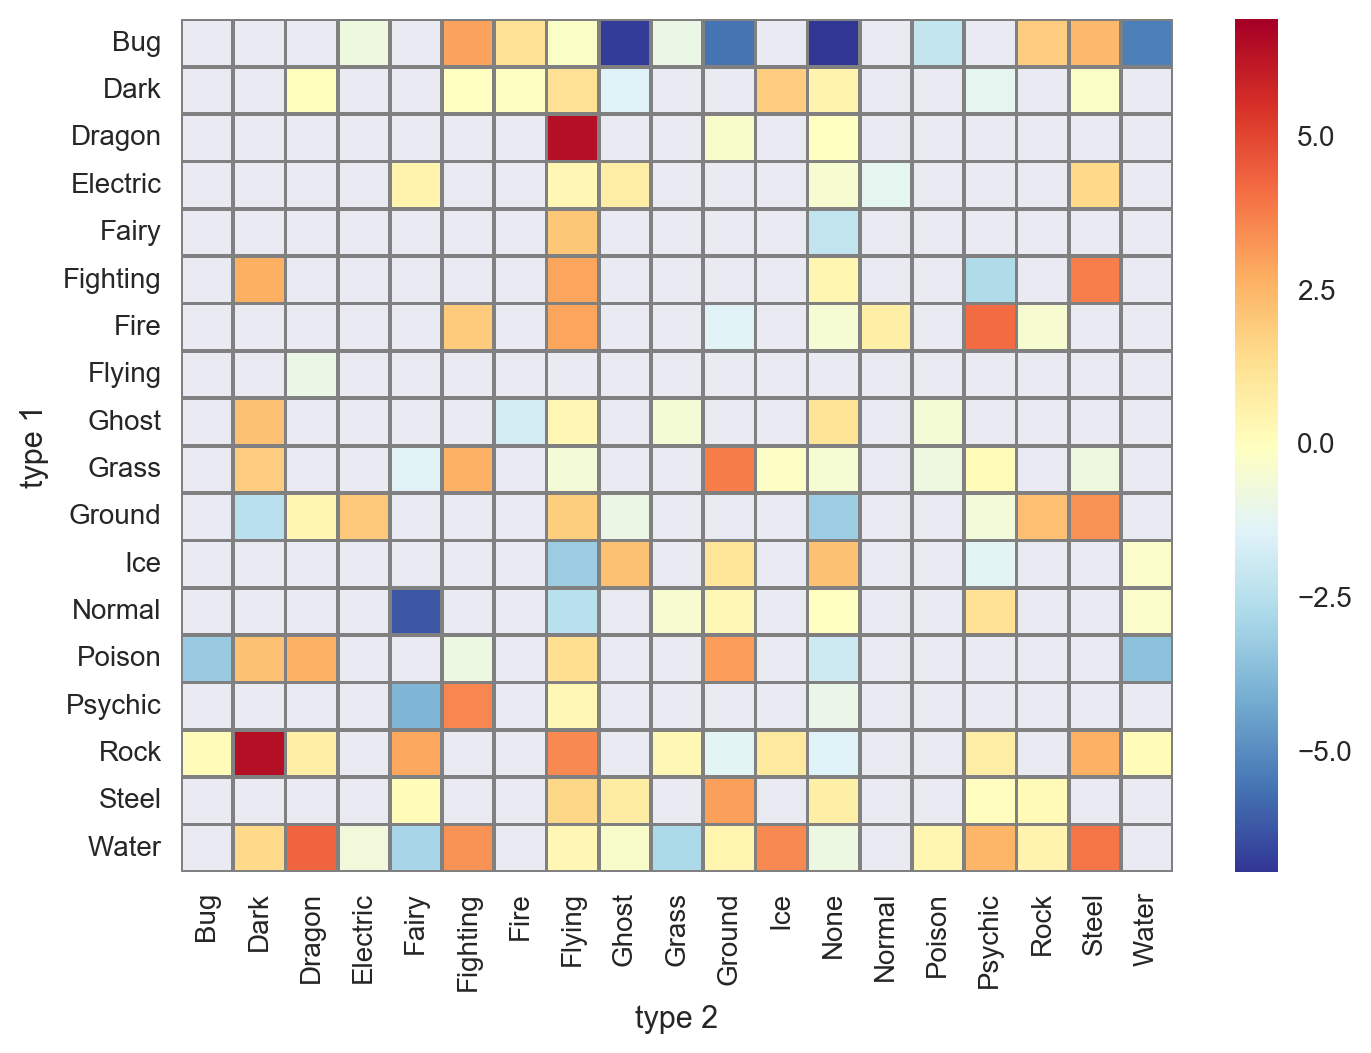

In [123]:
# Join the norm_stats table with the pokedex table based on id number for
# non-legendary Pokemon only
joined_nolegs = pd.merge(
    pokedex[~pokedex['legendary']],
    norm_stats,
    on='id'
)

# Calculate the median strength of each primary and secondary type combination
medians = joined_nolegs.groupby(['type 1', 'type 2'])['total'].median()

# Display a heatmap of the median strength of each primary and secondary type
# combination
sns.heatmap(
    medians.unstack(),
    linewidths=1,
    cmap='RdYlBu_r',
    linecolor='grey'
);

In [124]:
# Rearrange the medians table and sort by the strongest primary and secondary 
# type combination for non-legendary Pokemon species
medians.reset_index().sort_values('total', ascending=False).head()

,type 1,type 2,total
21,Dragon,Flying,6.480187
96,Rock,Dark,6.472608
115,Water,Dragon,4.344018
42,Fire,Psychic,4.201712
128,Water,Steel,4.003064


The results change a bit when excluding legendary Pokemon: Dragon-type are not as dominating, in fact, there more diversity in strength among types. This is also indicates that many legendary Pokemon species are Dragon-type. Unfortunately for Bug-type Pokemon, they're still among the weakest.

We have to be careful with the validity of these conclusions because the plots hide the number of Pokemon in each type combination, but as a rule of thumb, you shoot for Dragon-type but avoid Bug-type Pokemon species!

## 5. Are there any trends between a Pokemon's statistics and its type?


As certain Pokemon types are stronger than others, let's investigate whether a specific type excel at a given statistic. Again, since Pokemon species are generally defined by their primary type, let's analyze by primary types only.

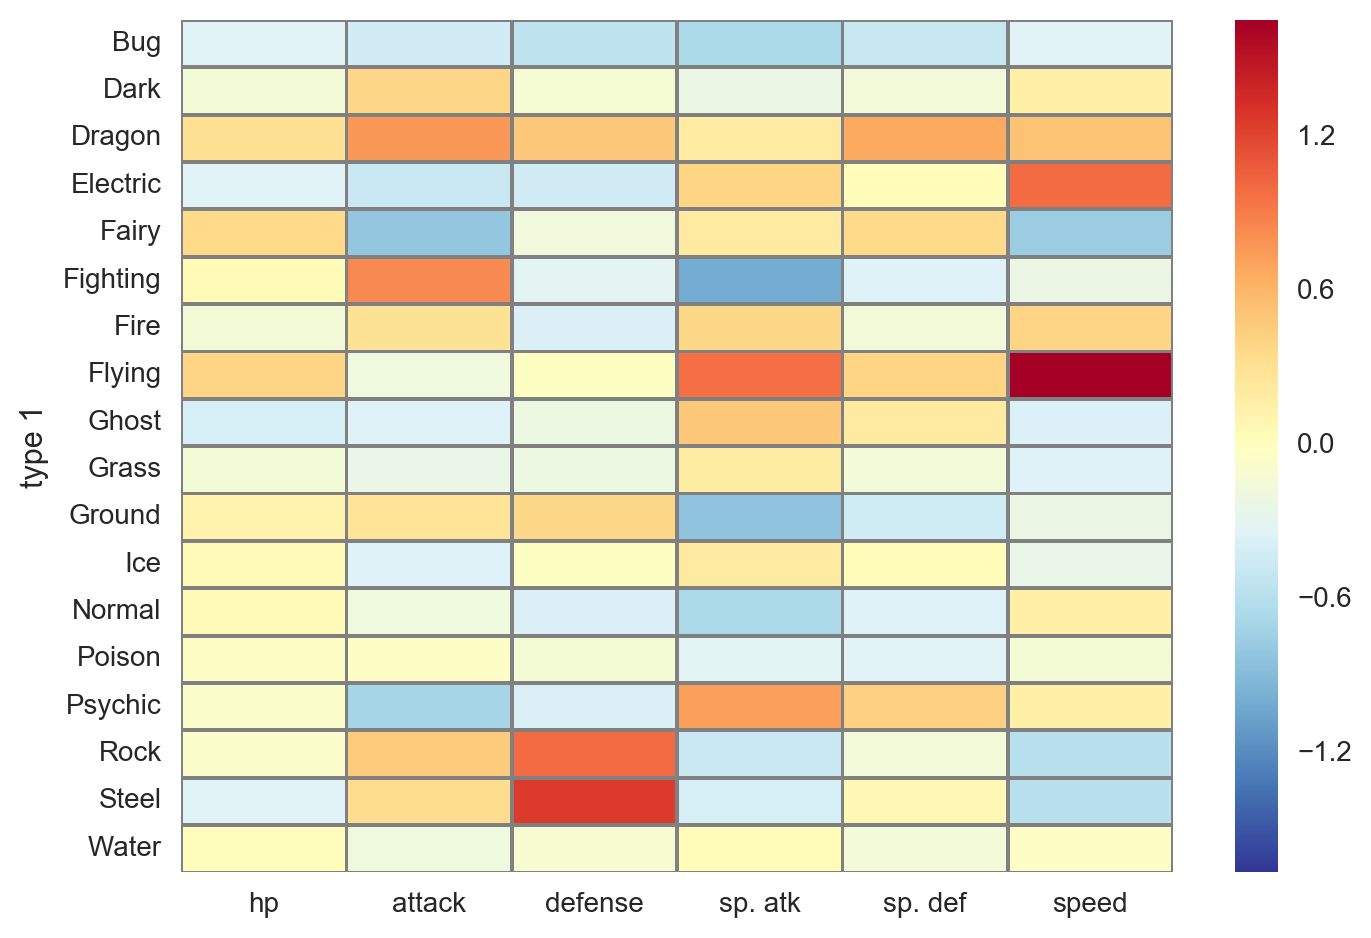

In [125]:
# Display a heatmap of the distribution of statistics across primary types
sns.heatmap(
    joined.groupby('type 1').median().loc[:, 'hp':'speed'], 
    linewidths=1,
    cmap='RdYlBu_r',
    linecolor='grey'
);

A few conclusions pop out of this plot:
- Flying-type Pokemon are really fast, which make intuitive sense.
- Among the Pokemon with the highest defense are Rock- and Steel-type Pokemon, again, making sense.

Since including legendary Pokemon species may be potentially hiding some interesting results, let's take a look at the same analysis again excluding legendary Pokemon.

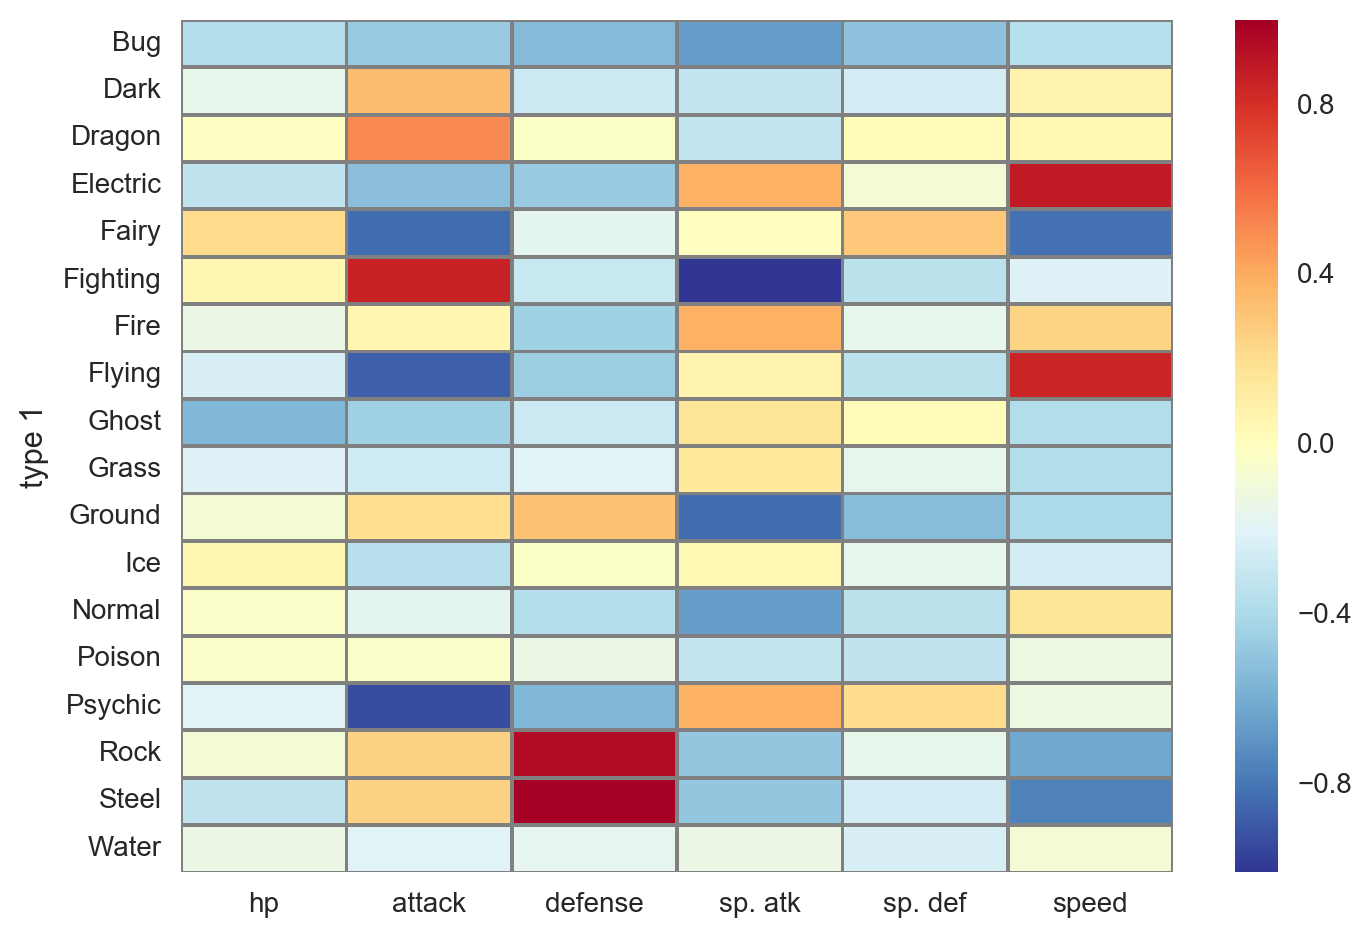

In [126]:
# Display a heatmap of the distribution of statistics across primary types
# for non-legendary Pokemon species
sns.heatmap(
    joined_nolegs.groupby('type 1').median().loc[:, 'hp':'speed'], 
    linewidths=1,
    cmap='RdYlBu_r',
    linecolor='grey'
);

This plot reveal a lot more when we exclude legendary Pokemon species:
- The fastest Pokemon are by far Flying-type and Electric-type, while Fairy-type and Steel-type are slowpokes.
- Fighting-type Pokemon have unparalleled attack power but the worst special attack power
- Psychic-type, Flying-type and Fairy-type Pokemon have terrible attack power.
- Rock- and Steel-type Pokemon still have the best defense.